## Prerequisites

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

# locate to working directory
%cd gdrive/MyDrive/Colab Notebooks/Konta		

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/Konta


In [102]:
# Import libraries
import os
import json
import re
import random
from pathlib import Path

import spacy
from spacy.gold import GoldParse
from spacy.scorer import Scorer

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#Problem 1

## Problem understanding 

The objective of this problem is to generate lines of text from words that have been detected by OCR. To do so, I will concatenate the words belonging to the same line.  

In general, a line of text is a combination of words that exist on the same line (and the same layout). In our case, the documents are not structured (there are tables and different layouts), which makes the notion of a line of text difficult to define. In my approach, I consider a line of text to be any combination of words that exist in the same Y coordinate range.  In other words, if two words are separable by a $\Delta(Y)$ greater than a given threshold, then they must belong to two different lines.   

We could also define a threshold for the X coordinates ($\Delta(X)$) to separate words that exist in the same Y range and belong to different layouts (see Example 1 below), but there are cases where even $\Delta(X)$ is large, the two words may have a specific meaning (and thus could define a line of text, see Example 2 below).  

The problem with this approach is that there could be words belonging to different layouts even with very close Y coordinates. This could be discussed with the business team to define an exact definition of a "line of text", and also to define the threshold to consider for $\Delta(Y)$, since this one depends on the usual shape of the scanned documents (usual distance between two lines of text). In this case, I will consider that for all words having very close y-coordinates ($\Delta(Y)$ higher than a given threshold), they belong to the same text line. For the threshold, I have performed some observation on the provided and I found that 2 is the best value to consider (The maximal distance between to word to be considered as belonging to the same line)


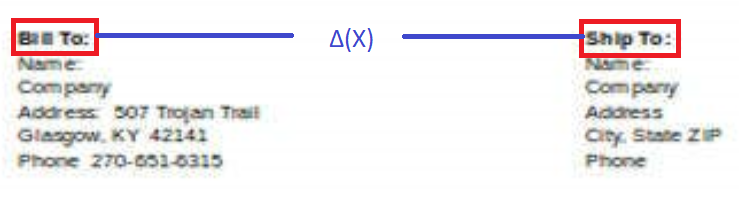

In [132]:
# Example 1
Image("Capture1.PNG")

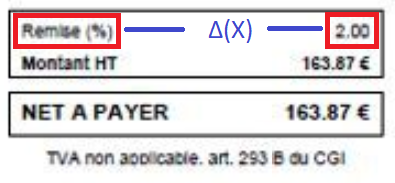

In [134]:
# Example 2
Image("Capture.PNG")

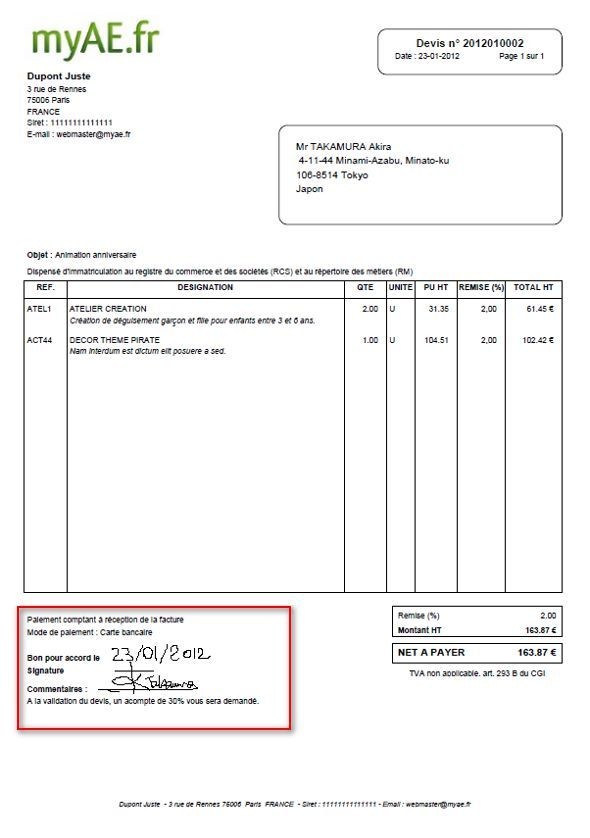

In [136]:
# Example 3
Image("IMAGE/10604.jpg")

The reason I chose this approach of defining a threshold on the Y coordinates is related to the quality of the data:  

The documents were not perfectly scanned (which is normal), and this resulted in a small orientation of the documents (there is a small $\alpha$ angle between the Y-axis of the document frame of reference (Y of the OCR) and the Y-axis of the document lines. See example 3). This means that even if two words exist in the same line, they can have different Y coordinates.  
Note: the value of alpha can be found by the following formula:  
Let $w1$ and $w2$ be two words that exist in the same line, and $(xi,yi)$, $(xj,yj)$ their center of gravity coordinates. Then:

$$\alpha = \frac{\lvert (yj-yi) \rvert}{\sqrt((xi-xj)^2+(yi-yj)^2}$$


### Pipeline

To generate the lines of text, I'm going to execute the following steps :  
1. Retrieve relevent data drom json files in a form of dictionary:  
    * X and Y gravity center coordinates of every word index 
    * The text associated with every word index
2. Sort X and Y coordinates dictionaries to facilitate the next steps
3. Iterate the Y coordinates dictionary and store index of words having $\Delta(Y)<=thresh$ in a new dictionary of lines.
4. Sort each list of words defining a line according to X coordinates (This will create an order in each line)


In [106]:
class Lines:
  def __init__(self, path, thresh):
    self.path = path
    self.thresh = thresh
    
  def read_json(self):
    """
    read json file and return relevent data for each document (index, gravity center coordinates and text)
    """
    docs = {}
    for j in os.listdir(self.path):
      f = os.path.join(self.path,j)
      if f.split('.')[-1]=='json':
        data = json.load(
            open(f))
        docs[j.split('.')[0]] = [w for w in data["pageFiles"]['1']['vertices']] # assuming that there is only 1 page in each document
    return docs
  
  def get_data(self):
    """
    Return dicts of text, X and Y coordinates associated with each word index
    """
    docs = self.read_json()
    self.X_all, self.Y_all, self.text_all = {},{},{}
    for k,doc in docs.items():
      X,Y,text = {},{},{}
      for word in doc:
        Y[word['index']] = word['gravityCenter']['y']
        X[word['index']] = word['gravityCenter']['x']
        text[word['index']] = word['text']
      self.X_all[k],self.Y_all[k],self.text_all[k]=X,Y,text
    return self.X_all,self.Y_all,self.text_all

  def words_to_lines(self, doc):
    """
    take a doc name as input and give as output a dictionary of lines of text in the document
    """
    X, Y, text = self.X_all[doc], self.Y_all[doc], self.text_all[doc]

    # Sort Y
    sorted_Y={k: v for k, v in sorted(Y.items(), key=lambda item: item[1])}
    # Sort X
    sorted_X={k: v for k, v in sorted(X.items(), key=lambda item: item[1])}
    # Dict containing lines of text
    lines={}
    # Dict index that we will increment
    i=0
    # Temp dict to work with
    temp = sorted_Y.copy()
    # 
    lines[0]=[]
    # store the first word in the first line
    lines[0].append(list(temp.keys())[0])
    # delete the first word from the temp dict 
    f = temp.pop(0)
    # 
    for k,v in temp.items():
      # keep adding words to the actual line (i) until we find a delta(Y)>thresh
      if abs(sorted_Y[lines[i][-1]]-v)>self.thresh:
        i+=1
        lines[i]=[]
        lines[i].append(k)
      else:
        lines[i].append(k)
    #lines_words = {k:[text[a] for a in v] for k,v in lines.items()}
    # sort lines by X to have an order
    for k,v in lines.items():
      lines[k]=sorted(v, key=lambda i: sorted_X[i])
    # convert the dict from lists of index to lists of words  
    lines_words = {k:[self.end_of_loop() if a>len(text)-1 else text[a] for a in v] for k,v in lines.items()}
    # convert the dict from lists of words to phrases
    self.lines_text = {k:' '.join(v) for k,v in lines_words.items()}
    return self.lines_text

lines = Lines("OCR", 2)
X_all, Y_all, text_all = lines.get_data()
print(lines.words_to_lines('10604'))

{0: 'myAE.fr', 1: 'Devis nº 2012010002', 2: 'Date : 23-01-2012 Page 1 sur 1', 3: 'Dupont Juste', 4: '3 rue de Rennes', 5: '75006 Paris', 6: 'FRANCE', 7: 'Siret : 11111111111111', 8: 'E - mail : webmaster @ myae .', 9: 'Mr TAKAMURA Akira', 10: '4-11-44 Minami - Azabu , Minato - ku', 11: '106-8514 Tokyo', 12: 'Japon', 13: 'Objet : Animation anniversaire', 14: 'Dispense immatriculation au registre du commerce et des societes ( RCS ) et au repertoire des meters ( RM )', 15: 'REF . DESIGNATION QTE UNITE PUHT REMISE ( % ) TOTAL HT', 16: 'ATEL1 ATELIER CREATION 2.00 U 31.35 2.00 61.45 €', 17: 'Creation de deguisement garçon et ne pour enfants entre 3 e 6 ans .', 18: 'ACT44 DECOR THEME PIRATE 1.00U 104.51 2,00 102.42 €', 19: 'Nam interdum est actum elt posuere a sed .', 20: 'Remise ( % ) 2.00', 21: 'Palement comptant a reception de la facture', 22: 'Montant HT 163.87 €', 23: 'Mode de palement : Carte bancaire', 24: 'NET A PAYER 163.87 €', 25: '23/01/2012', 26: 'son pour accord le', 27: 'Signat

# Problem 2

The objective of this problem is to extract TTC values from non structured text. DFor each sentence in the dataframe, a TTC label is associated (see Dataframe belllow).

In [107]:
train = pd.read_csv("PROBLEM2/train.csv")
test = pd.read_csv("PROBLEM2/test.csv")

train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)
train.head()

,sentence,label
0,"TTC 640,00","640,00"
1,"TOTAL A PAYEE 640,00 sad","640,00"
2,"Total 130,00 MAD","130,00"
3,"Sous Total 108,33 MAD TVA 21,67 MAD Total 130...","130,00"
4,"TOTAL FACTURE EN DIRHAMS TTC 350,00","350,00"


### First approach

If we look at the sentences, we can see that they contain one or more numbers, among which we can find the prices TVA and TTC. As we know, TTC represents "all taxes included", that is to say the sum of all the prices. Assuming that all numbers in the sentences represent only prices, TTC would be the maximum price in each sentence. Our first approach, which is based on this assumption, will be performed by following these steps:  
1. Using regex (re library), we will find all the numbers in each sentence and store them in a list.
2. Then we will convert them to float values to be able to compare them (we also need to replace ',' with '.'). The same step is done for the labels. 
3. Finally, we look for the maximum number in the sentence that would represent the label (TTC value).

In [108]:
# Split data into X_train, X_test, Y_train, Y_test for later use
X_train, X_test, Y_train, Y_test =\
         train["sentence"], test["sentence"], train["label"], test["label"]

def find_max(string):
  """
  Find all numbers in a sentence, 
  convert them to float (after rerplacing ',' with '.') 
  rounded by 2 digits and select the maximum one.
  """
  # This regex is used to select numbers rounded wih 4 digits.
  return max([round(float(s.replace(',','.')),2) for s in 
              re.findall(r"[-+]?\d*\,\d+|\d+|\d+|\d+", string)]) 

# Convert Y_train and Y_test to float rounded by 2 digit to match with extracted TTC
Y_train = np.array([round(float(w.replace(',','.')),2) for w in Y_train])
Y_test = np.array([round(float(w.replace(',','.')),2) for w in Y_test])
# Apply find_max function to all sentences in X_train and X_test
Y_regex_train = list(map(find_max, X_train))
Y_regex_test = list(map(find_max, X_test))

# We can check if the extracted TTC values 
# just by evaluating the boolean expression Y_regex==Y_train
print("Cheque if the extracted TTC values match all the actual labels in training data : ",list(Y_regex_train)==list(Y_train))
print("Cheque if the extracted TTC values match all the actual labels in training data : ",list(Y_regex_test)==list(Y_test))


Cheque if the extracted TTC values match all the actual labels in training data :  True
Cheque if the extracted TTC values match all the actual labels in training data :  True


In conclusion, this approach works well. But we still need more "out of the box" data to evaluate this approach and see if it is robust, and also to be able to validate the hypothesis I made earlier that all numbers in the sentences represent prices.


##Seconde approach

In this approach, I will train a NER (Named Entity Recognition) custom model using the Spacy library, following the steps below:  

1. Data preparation:  
* Replace ',' with '.' to have a unified float format in the text and labels. 
* Create a list of tuples containing the text, the label and the position of the label in the text. The position of a TTC value in the text is defined by a start and an end (generated with regex).  
2. Train a NER model using the data we just prepared.
3. Evaluate the model on the test data

In [109]:
# split data
X_train, X_test, Y_train, Y_test =\
         train["sentence"], test["sentence"], train["label"], test["label"]

# Replace ',' by '.'
def process(text):
  text = text.replace(',','.') 
  return text 

# apply the function
X_train = list(map(process, X_train))
X_test = list(map(process, X_test))
Y_train = list(map(process, Y_train))
Y_test = list(map(process, Y_test))

# Create the training data in an adequat format for the model
def prep_data(X,Y):
  DATA = []
  for text,label in zip(list(X), list(Y)):
    try:
      # look for the label position in he sentence
      a = re.search(r'\b({})\b'.format(str(label)), str(text))
      # we will always have only one entity in our case 
      # since there is only one TTC in each sentence
      DATA.append((text, {'entities':[(a.start(), a.end(), 'TTC')]}))
    # I did this expection to handle the problem 
    # where the label is not written as it is written in the sentence
    except Exception as e:
      continue
  return DATA
TRAIN_DATA = prep_data(X_train, Y_train)
print(len(X_train))
print(len(TRAIN_DATA))
print(TRAIN_DATA[0])

342
318
('TTC  640.00', {'entities': [(5, 11, 'TTC')]})


In [110]:
# number of iterations
n_iter=30

# load the model
nlp = spacy.blank('fr')  

# set up the pipeline
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner, last=True)
else:
    ner = nlp.get_pipe('ner')

# add the labels to the model
for _, labels in TRAIN_DATA:
    for ent in labels.get('entities'):
        ner.add_label(ent[2])

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.begin_training()
    losses_list=[]
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in TRAIN_DATA:
            nlp.update(
                [text],  
                [annotations],  
                drop=0.5,  
                sgd=optimizer,
                losses=losses)
        losses_list.append(losses)

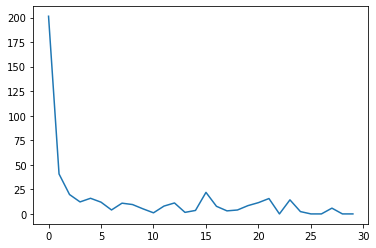

In [111]:
# Plot loss function 
plt.plot([list(v.values())[0] for v in losses_list])
plt.show()

In [112]:
# save the model
output_dir = "Model"
output_dir = Path(output_dir)
if not output_dir.exists():
    output_dir.mkdir()
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

Saved model to Model


In [113]:
# list of predictions
preds = []
# test the model on test data
i=0
for text, label in zip(X_test, Y_test):
    doc = nlp(text)
    pred = ''.join([ent.text for ent in doc.ents])
    # remove non numeric char from extracted TTC
    pred = ''.join(i for i in pred if i.isdigit() or i=='.')
    preds.append(pred)
    if i<8:
      print("Actual label : ", label, '--->' , "Predicted label : ", pred)
      i+=1

Actual label :  604.00 ---> Predicted label :  604.00
Actual label :  1020.00 ---> Predicted label :  1020.00
Actual label :  600.00 ---> Predicted label :  600.00
Actual label :  600.00 ---> Predicted label :  600.00
Actual label :  360.00 ---> Predicted label :  360.00
Actual label :  360.00 ---> Predicted label :  360.00
Actual label :  180.00 ---> Predicted label :  180.00
Actual label :  180.00 ---> Predicted label :  180.00


In [114]:
# prepare test data for evaluation
TEST_DATA = prep_data(X_test,Y_test)

In [115]:
def evaluate(ner_model, examples):
    scorer = Scorer()
    for input_, annot in examples:
        doc_gold_text = ner_model.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=annot['entities'])
        pred_value = ner_model(input_)
        scorer.score(pred_value, gold)
    print(scorer.scores)
    return scorer.scores

#ner_model = spacy.load(ner_model_path) # for spaCy's pretrained use 'en_core_web_sm'
results = evaluate(nlp, TEST_DATA)

{'uas': 0.0, 'las': 0.0, 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}}, 'ents_p': 100.0, 'ents_r': 98.73417721518987, 'ents_f': 99.36305732484078, 'ents_per_type': {'TTC': {'p': 100.0, 'r': 98.73417721518987, 'f': 99.36305732484078}}, 'tags_acc': 0.0, 'token_acc': 100.0, 'textcat_score': 0.0, 'textcats_per_cat': {}}


The F1 score is equal to 99.36, which is a good result.

In conclusion, regex showed better results compared to the NER model, since in the first approach I assumed that all the numbers existing in the sentences represent a price, and based on the definition of TTC, it must be the highest price. The second approach requires more data and that is cleaner (the TTC must have the same format, the same rounded numbers)